In [1]:
!pwd
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
'''
sys.path.append('/Users/suryaven/Documents/personal/sky/skyburst')
sys.path.append('/Users/suryaven/Documents/personal/sky/starburst/')
sys.path.append('/Users/suryaven/Documents/personal/sky/starburst/starburst/utils')
'''
# TODO: Generalize differences between sky laptop and personal latop paths
sys.path.append('/Users/surya/Documents/sky/skyburst/')
sys.path.append('/Users/surya/Documents/sky/starburst/')
sys.path.append('/Users/surya/Documents/sky/starburst/utils')

import starburst
import skyburst
from starburst import utils
import job_logs
import sampled_jobs
import plot_jobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import time 
import copy 
from collections import OrderedDict 
import math
pd.set_option('display.max_columns', None)


/Users/surya/Documents/sky/starburst/starburst/utils


In [2]:
LOGS = {
    "05_01_2023": 1682925843,
    "05_02_2023": 1683099273,
    "05_03_2023": 1683132152,
    "05_03_2023_2": 1683173965,
    "05_04_2023_1": 1683184792, 
    "05_04_2023_2": 1683196845,
    "05_04_2023_3": 1683259533,
    "05_05_2023_4": 1683343491,
    "05_06_2023_4": 1683410859,
    "05_06_2023_5": 1683418719,
    "05_06_2023_6": 1683442154,
    "05_06_2023_7": 1683452077,
    "05_07_2023_1": 1683486242,
    "05_07_2023_2": 1683489564,
    "05_07_2023_3": 1683496107,
    "05_07_2023_4": 1683497538,
    "1683498468": 1683497538, 
    "1683498857": 1683498857,
    "1683499283": 1683499283,
    "1683528723": 1683528723, # Fixed JCT values
    "1683534589": 1683534589, # Large sweep with greater arrival rates
    "1683607638": 1683607638, # Modified arrival rate values to match simulator
    "1683625643": 1683625643, # Policy waits until cluster state is updated
    "1683627780": 1683627780, # Policy waits until cluster state and running pods are updated
    "1683680278": 1683680278, # Sweep with uniform wait (4 sec) and constant timeout (3 sec)
}

logs = LOGS["1683680278"]

job_logs.pull_vm_scheduler_logs(event_number=logs, force=True)
jobs_df = job_logs.retrieve_df(event_number=logs, avoid_congestion=False)
jobs_df = jobs_df.assign(gpus_per_node=jobs_df['cpus_per_node'])

START TIMES {'sleep-0-370199': 1683680379, 'sleep-1-890856': 1683680383, 'sleep-2-587259': 1683680387, 'sleep-3-3252': 1683680391, 'sleep-4-949373': 1683680395, 'sleep-5-424671': 1683680400, 'sleep-6-25718': 1683680404, 'sleep-7-9944': 1683680408, 'sleep-8-856010': 1683680412, 'sleep-9-683501': 1683680416, 'sleep-10-276780': 1683680420, 'sleep-11-801109': 1683680425, 'sleep-12-369480': 1683680428, 'sleep-13-668616': 1683680432, 'sleep-14-283966': 1683680436, 'sleep-15-573025': 1683680440, 'sleep-16-920991': 1683680444, 'sleep-17-967156': 1683680448, 'sleep-18-419383': 1683680452, 'sleep-19-461386': 1683680456, 'sleep-20-907301': 1683680460, 'sleep-21-409949': 1683680464, 'sleep-22-268277': 1683680468, 'sleep-23-729070': 1683680473, 'sleep-24-154671': 1683680476, 'sleep-25-379587': 1683680480, 'sleep-26-960876': 1683680484, 'sleep-27-139494': 1683680488, 'sleep-28-124145': 1683680492, 'sleep-29-39650': 1683680496, 'sleep-30-519075': 1683680500, 'sleep-31-269583': 1683680504, 'sleep-32-4

In [3]:
jobs_df

,idx,runtime,arrival,num_gpus,allocated_gpus,start,instance_type,node_index,node,cpus,submission_time,wait_times,uniform_arrival,uniform_submission,waiting_policy,time_constrained,cluster_size,cpus_per_node,cloud_cluster_nodes,cloud_cpu_per_node,random_seed,total_jobs,batch_time,wait_time,time_out,mean_duration,arrival_rate,cpu_sizes,cpu_dist,gpu_sizes,gpu_dist,memory_sizes,memory_dict,varying_values,fixed_values,uniform_arrival_sweep,uniform_submission_sweep,waiting_policy_sweep,time_constrained_sweep,cluster_size_sweep,cpus_per_node_sweep,cloud_cluster_nodes_sweep,cloud_cpu_per_node_sweep,random_seed_sweep,total_jobs_sweep,batch_time_sweep,wait_time_sweep,time_out_sweep,mean_duration_sweep,arrival_rate_sweep,cpu_sizes_sweep,cpu_dist_sweep,gpu_sizes_sweep,gpu_dist_sweep,memory_sizes_sweep,memory_dict_sweep,gpus_per_node
0,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[16, 12, 53, 17, 4, 61, 5, 15, 13, 17, 10, 20,...","[2.481705904006958, 7.481705904006958, 11.4817...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{0: []}, {3: []}, {1: []}, {2: []}, {0: []}, ...","[2.481705904006958, 7.481705904006958, 11.4817...","[e2-standard-8, e2-standard-8, e2-standard-8, ...","[0, 3, 1, 2, 0, 3, 0, 1, 0, 2, 0, 1, 0, 0, 2, ...","[gke-starburst-cpu-workloads-04fa1bcf-b5bt, gk...","[2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, ...","[0.0, 3.98594331741333, 8.039539813995361, 11....","[2.481705904006958, 3.495762586593628, 3.44216...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.25,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]","(cpu_dist, wait_time, arrival_rate)","(batch_time, mean_duration, waiting_policy, cp...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.25,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",8
1,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[15, 12, 54, 17, 3, 61, 5, 15, 12, 19, 10, 20,...","[2.682251453399658, 6.682251453399658, 11.6822...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{3: []}, {0: []}, {1: []}, {2: []}, {3: []}, ...","[2.682251453399658, 6.682251453399658, 11.6822...","[e2-standard-8, e2-standard-8, e2-standard-8, ...","[3, 0, 1, 2, 3, 0, 3, 2, 3, 1, 3, 2, 3, 3, 1, ...","[gke-starburst-cpu-workloads-04fa1bcf-tsf4, gk...","[2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, ...","[0.0, 3.8979039192199707, 7.793416976928711, 1...","[2.682251453399658, 2.7843475341796875, 3.8888...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.5,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]","(cpu_dist, wait_time, arrival_rate)","(batch_time, mean_duration, waiting_policy, cp...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.5,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",8
2,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[16, 11, 53, 17, 4, 61, 5, 15, 12, 17, 10, 20,...","[3.64595103263855, 7.64595103263855, 11.645951...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{0: []}, {3: []}, {1: []}, {2: []}, {3: []}, ...","[3.64595103263855, 7.64595103263855, 11.645951...","[e2-standard-8, e2-standard-8, e2-standard-8, ...","[0, 3, 1, 2, 3, 0, 3, 2, 3, 1, 3, 2, 3, 3, 1, ...","[gke-starburst-cpu-workloads-04fa1bcf-b5bt, gk...","[2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, ...","[0.0, 3.9058754444122314, 7.965650320053101, 1...","[3.64595103263855, 3.7400755882263184, 3.68030...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.75,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]","(cpu_dist, wait_time, arrival_rate)","(batch_time, mean_duration, waiting_policy, cp...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.75,"[1, 2, 4]

In [4]:
jobs_df['arrival_mask'] = jobs_df['start'].apply(lambda x: [0 if not i else 1 for i in x])
jobs_df['onprem_mask'] = jobs_df['arrival_mask']

# CLIP WAITS

def cloud_wait_unclipped(row): 
    cloud_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait_unclipped'] = jobs_df.apply(cloud_wait_unclipped, axis=1)

def clipped_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_time'] for i, n in enumerate(row['arrival_mask']) if n == 0]
    new_wait = onprem_wait + cloud_wait
    return new_wait

jobs_df['wait_times'] = jobs_df.apply(clipped_wait, axis=1)

def cloud_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    cloud_wait = [k8s_scheduling_waiting_constant + row['wait_time'] for i, n in enumerate(row['arrival_mask']) if n == 0]
    return cloud_wait
jobs_df['cloud_wait'] = jobs_df.apply(cloud_wait, axis=1)


def onprem_wait(row): 
    k8s_scheduling_waiting_constant = 1 #wait_time_2
    onprem_wait = [row['wait_times'][i] for i, n in enumerate(row['arrival_mask']) if n == 1]
    return onprem_wait

jobs_df['onprem_wait'] = jobs_df.apply(onprem_wait, axis=1)

# COMPUTE METRICS

jobs_df['avg_wait'] = jobs_df['wait_times'].apply(lambda x: sum(x)/len(x))
jobs_df['avg_runtime'] = jobs_df['runtime'].apply(lambda x: sum(x)/len(x))

def compute_total_time(row):
    total_time = [row['wait_times'][i] + row['runtime'][i] for i in range(len(row['wait_times']))]
    return total_time

jobs_df['total_time'] = jobs_df.apply(compute_total_time, axis=1)

def compute_completion_time(row):
    completion_time = [row['total_time'][i] + row['submission_time'][i] for i in range(len(row['wait_times']))]
    return completion_time

jobs_df['completion_time'] = jobs_df.apply(compute_completion_time, axis=1)
jobs_df['avg_jct'] = jobs_df['total_time'].apply(lambda x: sum(x)/len(x))

def compute_cluster_utilization(row):
    surface_area = [row['runtime'][i] * row['cpus'][i] for i in range(len(row['runtime']))]
    utilized_surface_area = sum(surface_area)
    total_surface_area = (max(row['completion_time']) - min(row['submission_time'])) * (row['cpus_per_node'] * row['cluster_size'])
    cluster_utilization = utilized_surface_area/total_surface_area
    return cluster_utilization

jobs_df['cluster_utilization'] = jobs_df.apply(compute_cluster_utilization, axis=1)

def compute_system_utilization(row):
    # TODO: Compute this value correctly
    return system_utilization

#jobs_df['cluster_utilization'] = jobs_df.apply(compute_cluster_utilization, axis=1)

GCP_PRICES = {
	"e2-medium": 0.038795,
	"e2-standard-8": 0.31036,
	"unknown": 0.038795,
}

def compute_total_cost(row):
    # TODO: Compute this value correctly
    # Get all cloud runtimes + submit 
    total_time = [row['runtime'][i] * i * GCP_PRICES[row['instance_type']] for i in range(len(row['onprem_mask']))]
    return system_utilization

jobs_df['total_cloud_cost'] = jobs_df.apply(compute_cluster_utilization, axis=1)


In [5]:
jobs_df

,idx,runtime,arrival,num_gpus,allocated_gpus,start,instance_type,node_index,node,cpus,submission_time,wait_times,uniform_arrival,uniform_submission,waiting_policy,time_constrained,cluster_size,cpus_per_node,cloud_cluster_nodes,cloud_cpu_per_node,random_seed,total_jobs,batch_time,wait_time,time_out,mean_duration,arrival_rate,cpu_sizes,cpu_dist,gpu_sizes,gpu_dist,memory_sizes,memory_dict,varying_values,fixed_values,uniform_arrival_sweep,uniform_submission_sweep,waiting_policy_sweep,time_constrained_sweep,cluster_size_sweep,cpus_per_node_sweep,cloud_cluster_nodes_sweep,cloud_cpu_per_node_sweep,random_seed_sweep,total_jobs_sweep,batch_time_sweep,wait_time_sweep,time_out_sweep,mean_duration_sweep,arrival_rate_sweep,cpu_sizes_sweep,cpu_dist_sweep,gpu_sizes_sweep,gpu_dist_sweep,memory_sizes_sweep,memory_dict_sweep,gpus_per_node,arrival_mask,onprem_mask,cloud_wait_unclipped,cloud_wait,onprem_wait,avg_wait,avg_runtime,total_time,completion_time,avg_jct,cluster_utilization,total_cloud_cost
0,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[16, 12, 53, 17, 4, 61, 5, 15, 13, 17, 10, 20,...","[2.481705904006958, 7.481705904006958, 11.4817...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{0: []}, {3: []}, {1: []}, {2: []}, {0: []}, ...","[2.481705904006958, 7.481705904006958, 11.4817...","[e2-standard-8, e2-standard-8, e2-standard-8, ...","[0, 3, 1, 2, 0, 3, 0, 1, 0, 2, 0, 1, 0, 0, 2, ...","[gke-starburst-cpu-workloads-04fa1bcf-b5bt, gk...","[2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, ...","[0.0, 3.98594331741333, 8.039539813995361, 11....","[2.481705904006958, 3.495762586593628, 3.44216...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.25,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]","(cpu_dist, wait_time, arrival_rate)","(batch_time, mean_duration, waiting_policy, cp...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.25,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],"[2.481705904006958, 3.495762586593628, 3.44216...",3.417973,19.627907,"[18.481705904006958, 15.495762586593628, 56.44...","[18.481705904006958, 19.481705904006958, 64.48...",23.045880,0.216533,0.216533
1,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[15, 12, 54, 17, 3, 61, 5, 15, 12, 19, 10, 20,...","[2.682251453399658, 6.682251453399658, 11.6822...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[{3: []}, {0: []}, {1: []}, {2: []}, {3: []}, ...","[2.682251453399658, 6.682251453399658, 11.6822...","[e2-standard-8, e2-standard-8, e2-standard-8, ...","[3, 0, 1, 2, 3, 0, 3, 2, 3, 1, 3, 2, 3, 3, 1, ...","[gke-starburst-cpu-workloads-04fa1bcf-tsf4, gk...","[2, 2, 1, 4, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, ...","[0.0, 3.8979039192199707, 7.793416976928711, 1...","[2.682251453399658, 2.7843475341796875, 3.8888...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.5,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]","(cpu_dist, wait_time, arrival_rate)","(batch_time, mean_duration, waiting_policy, cp...",4,True,fifo_wait,True,4,8,4,8,0,100,180,3,5,15,0.5,"[1, 2, 4]","[0.6, 0.25, 0.15]","[1, 2, 4, 8, 16, 32]","[0, 0.2, 0.2, 0.2, 0.2, 0.2]","[100, 500, 1000, 50000]","[0.25, 0.25, 0.25, 0.25]",8,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],"[2.682251453399658, 2.7843475341796875, 3.8888...",3.774183,19.500000,"[17.682251453399658, 14.784347534179688, 57.88...","[17.682251453399658, 18.682251453399658, 65.68...",23.274183,0.222431,0.222431
2,"[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...","[16, 11, 53, 17, 4, 61, 5, 15, 12, 17, 10, 20,...","[3.64595103263855, 7.64595103263855, 11.645951...","[1, 1, 1, 1, 1, 1, 1, 

In [6]:
jobs_df.filter(['arrival_rate', 'total_cloud_cost', 'wait_time', 'avg_jct'])

,arrival_rate,total_cloud_cost,wait_time,avg_jct
0,0.25,0.216533,3,23.045880
1,0.5,0.222431,3,23.274183
2,0.75,0.222784,3,23.248503
3,1.0,0.217201,3,23.693698
4,1.25,0.220641,3,23.729572
5,1.5,0.220426,3,23.435944
6,1.75,0.214691,3,23.566196
7,2.0,0.221389,3,22.597710
8,2.5,0.220905,3,22.527007
9,3,0.217011,3,22.895135


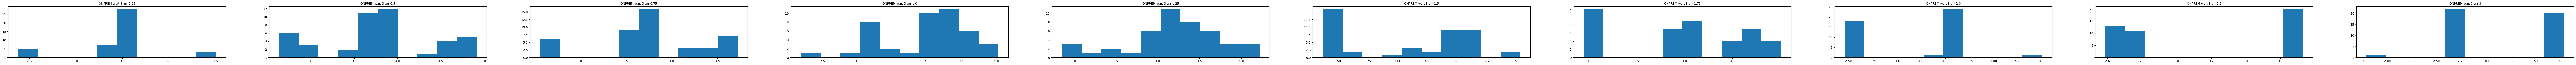

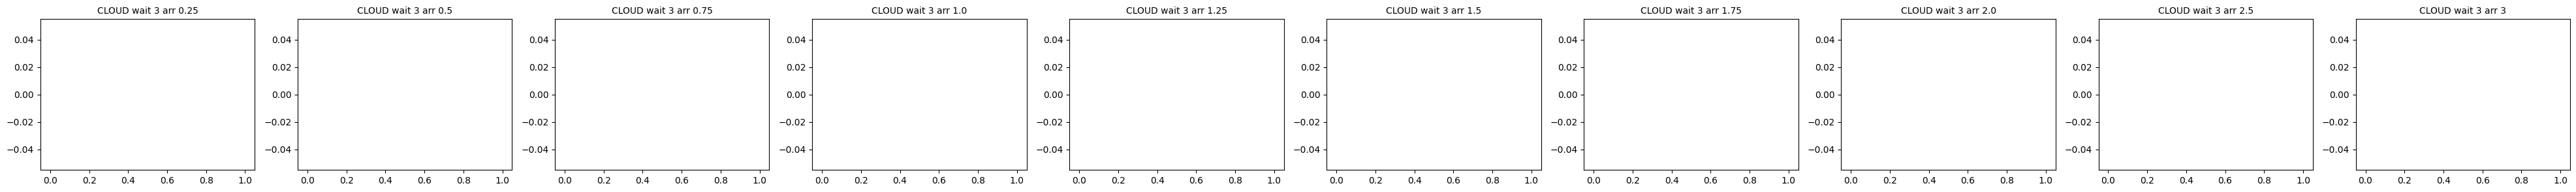

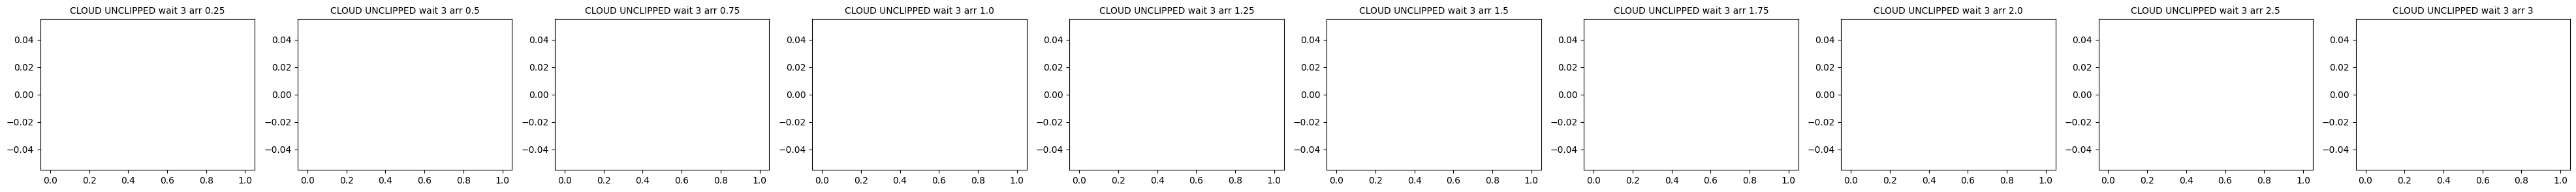

In [8]:
#jobs_wait = jobs_df.filter(['waiting_policy', 'wait_time', 'wait_times', 'arrival', 'start', 'submission_time', 'arrival_rate', 'arrival_mask'])
#TODO: Plot separate graphs for onprem and cloud
#def wait_time_histograms(jobs_df):
def wait_time_histograms(row):
    #import pdb; pdb.set_trace()
    fig, axs = plt.subplots(nrows=1, ncols=len(jobs_df), figsize=(150, 3)) 
    
    for i in range(len(jobs_df)):
        try: 
            axs[i].set_title("ONPREM " + "wait " + str(jobs_df['wait_time'][i]) +  " arr " + str(jobs_df['arrival_rate'][i]), fontsize=10)
            axs[i].hist(jobs_df['onprem_wait'][i], bin=10)
            print(jobs_df['onprem_wait'][i])
            average = sum(jobs_df['onprem_wait'][i])/len(jobs_df['onprem_wait'][i])
            print(average)
            axs[i].axvline(average, color='r', linewidth=5)
        except: 
            continue

    fig, axs = plt.subplots(nrows=1, ncols=len(jobs_df), figsize=(50, 3)) 
    for i in range(len(jobs_df)):
        try: 
            axs[i].set_title("CLOUD " + "wait " + str(jobs_df['wait_time'][i]) +  " arr " + str(jobs_df['arrival_rate'][i]), fontsize=10)
            axs[i].hist(jobs_df['cloud_wait'][i])
        except: 
            continue

    fig, axs = plt.subplots(nrows=1, ncols=len(jobs_df), figsize=(50, 3)) 
    for i in range(len(jobs_df)):
        try: 
            axs[i].set_title("CLOUD UNCLIPPED " + "wait " + str(jobs_df['wait_time'][i]) +  " arr " + str(jobs_df['arrival_rate'][i]), fontsize=10)
            axs[i].hist(jobs_df['cloud_wait_unclipped'][i])
        except: 
            continue
    
#wait_time_histograms(jobs_df)

jobs_df.apply(wait_time_histograms, axis=1)

In [ ]:
gpus_per_node = 32
avoid_congestion = True
print(gpus_per_node)

import heapq 

def cpu_index_mapping(jobs=None, gpus_per_node=8):
    #TODO: Implemement greedy algorithm to plot cpu indices
    '''
    Add all jobs to queue, then greedily assign indicies 

    Have priority queue for each node with "Free indices" sorted by index number 

    Iterate over all start times 

    TODO: Verify allocated_notes
    TODO: Determine how parsing changes between http_info and default values 
    '''
    GPUS_PER_NODE = gpus_per_node
    #allocated_nodes = jobs['allocated_gpus']#jobs['scheduled_nodes'].values()
    
    allocated_nodes = jobs['node_index']
    cpus = jobs['cpus']
    nodes = set(allocated_nodes)
    
    '''
    #for node_indices in allocated_nodes: 
    #    for index in node_indices: 
    #        nodes.add(index)
    #print("TOTAL NODES: ")
    #print(nodes)
    #print("")
    '''
    
    node_jobs ={}
    node_queues = {}
    for node in nodes:
        node_queues[node] = [i + 1 for i in range(GPUS_PER_NODE)]#8)]#128)]#8)] #heapq.heapify([i + 1 for i in range(8)]) #12-cpus -- 100 -- 256
        node_jobs[node] = []
        #print(node_queues)
        
    '''
    print("ALL NODE QUEUES")
    print(node_queues)
    print("ALL JOBS")
    print(jobs)
    '''

    # TODO: Create a list of times that include all arrival times and completion times in the same list in numerical order 
    global_queue = [] #heapq.heapify([])
    job_id_to_index = {}

    for i in range(len(jobs['arrival'])):
        # Remove values from queue
        job_id = jobs['idx'][i]
        job_id_to_index[job_id] = i
        job_node = jobs['node_index'][i]
        job_cpu_size = jobs['cpus'][i]
        # TODO: Verify arrival value is accurate
        job_arrival = jobs['arrival'][i]
        job_runtime = jobs['runtime'][i]
        
        '''
        print("JOB NODE")
        print(job_node)
        '''
        
        while global_queue and global_queue[0][0] <= job_arrival: 
            end_time, end_job_id = heapq.heappop(global_queue)
            released_index = job_id_to_index[end_job_id]
            #released_cpus = jobs['allocated_gpus'][released_index].keys()[0] #job_id_to_index[end_job_id]]#end_job_id]
            for released_node in jobs['allocated_gpus'][released_index]: 
                released_cpus = jobs['allocated_gpus'][released_index][released_node]
                #released_node = jobs['node_index'][released_index]
                released_node_queue = node_queues[released_node]
                node_jobs[released_node].remove(end_job_id)
                for cpu in released_cpus: 
                    heapq.heappush(released_node_queue, cpu)

        heapq.heappush(global_queue, (job_arrival + job_runtime, job_id))
        
        '''
        #print("GLOBAL QUEUE") # Queue sorted on end time -- earliest to latest end time
        #print(global_queue)
        #print("CPU_SIZE")
        #print(job_cpu_size)
        #print("NODE_QUEUE")
        #print(node_queue)
        '''

        job_allocated_cpus = []
        node_queue = node_queues[job_node]
        node_jobs[job_node].append(job_id)
        
        '''
        print("CPU_SIZE")
        print(job_cpu_size)
        print("NODE_QUEUE")
        print(node_queue)
        '''
        for j in range(job_cpu_size): 
            cpu_index = heapq.heappop(node_queue)
            job_allocated_cpus.append(cpu_index)
            
        jobs['allocated_gpus'][i] = {job_node: job_allocated_cpus}

    return jobs

def generate_gantt_chart(row):
    # TODO: Modify function to plot CPU jobs --> number of jobs concurrently running may exceed cpu count
    '''
    Create "threads index" that track CPU jobs running together
    '''
    save=False
    path=None
    subplt=None
    plt_index=None
    tag=None
    scale=1
    plot_sweep=False
    
    ratio=(1, 1)
    gpus_per_node=8
    fig, ax = plt.subplots()
    
    GPUS_PER_NODE = row['cpus_per_node']#gpus_per_node 
    jobs = cpu_index_mapping(row, gpus_per_node)
    jobs = jobs.copy()
    #TODO: Plot color based on job start time and not job index
    NUM_COLORS = len(row['idx']) + 5
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1. * i / NUM_COLORS) for i in range(NUM_COLORS)]
    
    y_lim_min = 1000
    y_lim_max = -1000
    num_nodes = row['cluster_size'] + row['cloud_cluster_nodes']
    
    total_gpus = num_nodes * GPUS_PER_NODE #GPUs equivalent to CPUs
    segment_height_list = {}
    gpu_indices = {}
    node_name = ""
    try: 
        for j_idx in range(len(row['idx'])):
            allocated_gpus = row['allocated_gpus'][j_idx]
            segment = (row['arrival'][j_idx],
                        row['arrival'][j_idx] + row['runtime'][j_idx], j_idx)

            node_name = row['node'][j_idx]
            for node_idx in allocated_gpus.keys():
                for node_gpu_idx in allocated_gpus[node_idx]:
                    gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx +
                                            node_gpu_idx)
                    gpu_indices[node_name] = [gpu_idx]
                    y_lim_min = min(y_lim_min, gpu_idx)
                    y_lim_max = max(y_lim_max, gpu_idx)
                    # TODO: Label each row of jobs with the name of the node -- not just integers 
                    plt.barh(gpu_idx,
                                width=row['runtime'][j_idx],
                                edgecolor='black',
                                height=1.0,
                                left=segment[0],
                                align='edge',
                                color=colors[row['idx'][j_idx]] if row['idx'][j_idx] < len(colors) else None,
                                alpha = 0.5)    
    except Exception as e: 
        print(e)

    for i in range(total_gpus + 1):
        multiplier = math.ceil(num_nodes / 32)
        if (i + 1) % GPUS_PER_NODE == 1:
            plt.axhline(y=i + 1, linewidth=0.75 / multiplier, color='black')
        else:
            pass

    max_arrival = max(row['arrival'])
    completions = [row['arrival'][i] + row['runtime'][i] for i in range(len(jobs['arrival']))]
    max_completion = max(completions)

    x_lim_max = max_completion

    
    last_job_time = max(row['completion_time'])    
    #dim=(-100, 100, 0, last_job_time)
    dim=(y_lim_min, y_lim_max, 0, last_job_time)
    bottom, top, left, right = dim
    plt.ylim(bottom=bottom, top=top)
    plt.xlim(left=left, right=right)
    #plt.axvline(x=max_completion, color='brown', linewidth=0.75)
    plt.axvline(x=max_arrival, color='brown', linewidth=0.75)
    plt.xlabel('Time')
    plt.ylabel('Nodes ')
    plt.title(str(tag))

    # TODO: Determine why jobs dissapaear when strings labels are used for nodes
    gpu_labels = sorted([(v, k) for k, v in gpu_indices.items()])
    ticks = [label[0] for label in gpu_labels]
    ticks = np.array(ticks)
    ticks = ticks.flatten()
    labels = [label[1] for label in gpu_labels]
    labels = np.array(labels)
    labels = labels.flatten()
    plt.yticks(ticks)
    ax.set_yticklabels(labels)
    
    if save:
        if path: 
            plt.savefig(path)
            plt.close()
    else:

        plt.show()

jobs_df.apply(generate_gantt_chart, axis=1)

# TODO: Rewrite this function to take in dataframe (do not parse data from logs)
#data = job_logs.view_real_arrival_times(event_number=logs, scale=0.5, plot_sweep=True, get_data=False, dim=(-100, 100, 0, 100), ratio=(5, 75), gpus_per_node = gpus_per_node, avoid_congestion=avoid_congestion, clip_last_job=True)

In [ ]:
'''
metrics_df = pd.DataFrame.from_dict(metrics)
metrics_df = metrics_df.transpose()
metrics_df.keys()
metrics_df.values()
t_metrics_df = metrics_df.transpose()
t_metrics_df= t_metrics_df.rename(columns={'cpus_per_node': 'gpus_per_node'})
t_metrics_df.keys()
'''

def new_plotting_function():
    return 0 

def skyburst_plotting_function(): 
    return 0 

def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    #ax.tick_params(bottom=False, left=False)
    ax.tick_params(bottom=True, left=False)
    ax.set_axisbelow(True)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    'constant': 'Constant',
    'linear_runtime': 'Runtime',
    'linear_cost': 'Cost',
    'zero': 'No Wait',
    'linear_runtime_filter_cpu': 'Runtime-Preempt-CPU'
}

def join_baseline(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    return diff_df
    
def get_default(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
        
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        print(k)
        print(v)
        print(df[k])
        #print(df[k]==v)
        #df[k] = df[k].apply(lambda x: [0, 0, 0] if len(x) != 3 else x)
        #print(df[k].eq(v))
        
        
        mask = df[k].apply(lambda x: x == v)
        print(mask)
        if isinstance(v, list):
            df = df[mask]
            #df[k].eq(v)
            #df[k] = df[k].apply(lambda x: [0, 0, 0] if len(x) != 3 else x)
            #df = df[df[k].eq(v)]
            
        #df = df[df[k]==v]
        
    return df
    
def get_baseline(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():        
        mask = df[k].apply(lambda x: x == v)
        if isinstance(v, list):
            df = df[mask]
    
    baseline_df = df
    
    for k,v in baseline_filter.items():
        #assert not isinstance(v, list)
        #baseline_df = baseline_df[baseline_df[k]==v]
        mask = baseline_df[k].apply(lambda x: x == v)
        baseline_df = baseline_df[mask]
        baseline_df = df[mask]
        #print(mask)
        #if isinstance(v, list):
            #df[k].eq(v)
            #df[k] = df[k].apply(lambda x: [0, 0, 0] if len(x) != 3 else x)
            #df = df[df[k].eq(v)]
            
        #df = df[df[k]!=v]
    
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            #print(avg_job_volume_rate)
            #print(df['cluster_size'].iloc[0])
            #print(df['gpus_per_node'].iloc[0])
            #print(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        
    #return baseline_df
    return diff_df

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False,
                          fig_ratio=(5, 3.5)):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(fig_ratio[0]*len(y_axis), fig_ratio[1]))
    
    if len(y_axis) == 1: 
        if not isinstance(axs, list):
            axs = [axs]
    print(axs)
    #time.sleep(1000)
    
    '''
    for k,v in df_filter.items():
        if isinstance(v, list):
            df = df[df[k]==v]
    '''

    for k,v in df_filter.items():        
        mask = df[k].apply(lambda x: x == v)
        if isinstance(v, list):
            df = df[mask]
       
    baseline_df = df
    
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
        
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            # Volume rate => runtime must be in either hours or seconds 
            '''
            Verification: 
            - Arrival_Rate = VERIFIED ~ error 
            - Num_gpus = Verified
            - Runtime = Verified 
            '''
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            df['z_mean_runtime'] = np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            df['z_cluster_nodes'] = (df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            #print(avg_job_volume_rate)
            #print(df['cluster_size'].iloc[0])
            #print(df['gpus_per_node'].iloc[0])
            #print(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    #print(df)
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
#         if 'waiting_policy' in groupby_values[0]:
#             label = [legend_dict[label[0]]] + list(label[1:])
#             print(label)
        for ax_idx, ax in enumerate(axs):           
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()  

In [ ]:
jobs_df

In [ ]:
# TODO: Add spec to increase plot size

#dists = [[0.2, 0.4, 0.4], [0, 0.5, 0.5], [0, 0, 1]]
dists = [[0.6, 0.25, 0.15]]#[[0, 0.5, 0.5]]
scale = 4
for dist in dists:
    simulator_plotting_fn(jobs_df, x_axis='arrival_rate', \
                          y_axis=['avg_jct', 'cluster_utilization'],\
                          #['total_cloud_cost'], 
                          #['avg_jct'],\
                          #[avg_jct', 'total_cloud_cost'], \
                          df_filter={'cpu_dist': dist}, 
                          #baseline_filter= {'wait_time': 1.0}, \
                          #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 0.0}, \
                          baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 2.5}, \
                          #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 1.0}, \
                          #groupby_values=['waiting_policy', 'wait_time'], normalize_x_axis=True, \
                          groupby_values=['wait_time'], normalize_x_axis=True, \
                          fig_ratio=(5*scale, 3.5*scale))
    


In [ ]:
default_df = get_default(jobs_df, x_axis='arrival_rate', y_axis=['avg_jct'], \
                           #df_filter={'cpu_dist': [0.2, 0.4, 0.4]}, \
                         #df_filter={'cpu_dist': [0.0, 0.5, 0.5]}, \
                         df_filter={'cpu_dist': [0.6, 0.25, 0.15]}, \
                          #df_filter={'wait_time': 1.0}, \
                      #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 1.0}, \
                          #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 0.0}, \
                         baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 0}, \
                           groupby_values=['waiting_policy'], normalize_x_axis=True)


baseline_df = get_baseline(jobs_df, x_axis='arrival_rate', y_axis=['avg_jct'], \
                           #df_filter={'cpu_dist': [0.2, 0.4, 0.4]}, \
                           #df_filter={'cpu_dist': [0.0, 0.5, 0.5]}, \
                           df_filter={'cpu_dist': [0.6, 0.25, 0.15]},
                      #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 1.0}, \
                           baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 0}, \
                           groupby_values=['waiting_policy'], normalize_x_axis=True)


merged_df = join_baseline(jobs_df, x_axis='arrival_rate', y_axis=['avg_jct', 'total_cloud_cost'], \
                          #baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 1.0}, \
                          baseline_filter= {'waiting_policy': 'fifo_wait', 'wait_time': 0}, \
                      groupby_values=['waiting_policy'], normalize_x_axis=True)
default_df, baseline_df, merged_df

In [ ]:
#jobs_df

In [ ]:
hyp = copy.deepcopy(sampled_jobs.DEFAULT_HYPERPARAMETERS)

hyp['arrival_rate'] = 10
hyp['batch_time'] = 600
hyp['total_jobs'] = 5
hyp['mean_duration'] = 60
arrived_jobs, arrivals = sampled_jobs.generate_jobs(hyp)

#print(arrived_jobs)
#print(arrivals)

In [ ]:
## HYPERPARAMETER
'''
Vary arrival rate
    - CPU jobs for Philly/Helios
        
- Mimic GPU jobs ~ with CPU
    - vary # jobs per minute 
    - test contant waiting for baseline
    - 0(Baseline), 0.25, 0.5, 1 ratio of runtime for waiting policy 
        - 
    
- Plot Cluster Utilization 
- Plot Cloud Cost 
'''